In [ ]:
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.ensemble import StackingClassifier

seed=42

In [8]:
df = pd.read_csv('parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


# Exploring Data

In [3]:
df.shape

(195, 24)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [5]:
print(Counter(df['status']))

Counter({1: 147, 0: 48})


In [6]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

# Extract features and labels from dataset

In [9]:
features=df.loc[:,df.columns!='status'].values[:,1:]
labels=df.loc[:,'status'].values[:]#or use just .values for a column

# Displaying extracted features and labels

In [10]:
print(features.shape)
print(labels.shape)

display(features)
labels[:]

(195, 22)
(195,)


array([[119.992, 157.302, 74.997, ..., 0.266482, 2.301442, 0.284654],
       [122.4, 148.65, 113.819, ..., 0.33559, 2.486855, 0.368674],
       [116.682, 131.111, 111.555, ..., 0.311173, 2.342259, 0.332634],
       ...,
       [174.688, 240.005, 74.287, ..., 0.158453, 2.679772, 0.131728],
       [198.764, 396.961, 74.904, ..., 0.207454, 2.138608, 0.123306],
       [214.289, 260.277, 77.973, ..., 0.190667, 2.555477, 0.148569]],
      dtype=object)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [11]:
#Count of 0/1 in labels
print('No. of 1s :{}'.format(labels[labels==1].shape[0]))
print('No. of 0s :{}'.format(labels[labels==0].shape[0]))

No. of 1s :147
No. of 0s :48


# Split the dataset

In [15]:
X = df.drop(['name','status'],axis=1)
y = df['status']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=seed)

In [18]:
print(x_train.shape)
print(y_train.shape)

(156, 22)
(156,)


# Train the model

In [19]:
model=XGBClassifier()
model.fit(x_train,y_train)

C:\Users\JAISHANKAR\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Logistic Regression

In [20]:
parameters = {'penalty': ['l1', 'l2'], 
              'C': [0.1, 0.4, 0.8, 1, 2, 5,10,20,30]}    

grid_search=GridSearchCV(estimator=LogisticRegression() ,param_grid=parameters,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(x_train,y_train)

log_reg = grid_search.best_estimator_

grid_search.best_params_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.80708333        nan 0.8325            nan 0.85125
        nan 0.85125           nan 0.83875           nan 0.84583333
        nan 0.84583333        nan 0.83958333        nan 0.84583333]
  warnings.warn(
C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 0.8, 'penalty': 'l2'}

In [21]:
y_pred=log_reg.predict(x_test)

print("\n",confusion_matrix(y_test,y_pred))
log_reg_acc = accuracy_score(y_test,y_pred)

print("\nAccuracy Score {}".format(log_reg_acc))


 [[ 3  4]
 [ 0 32]]

Accuracy Score 0.8974358974358975


# Support Vector Classifier

In [22]:
from sklearn.svm import LinearSVC

svc = LinearSVC()

parameters = {
      'penalty':['l1', 'l2'],
      'max_iter': [10,20,50,100,1000], 
      'C': [0.1, 0.4, 0.8, 1, 2, 5,10,20,30],          
              }

grid_search=GridSearchCV(estimator=svc ,param_grid=parameters,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(x_train,y_train)

svc = grid_search.best_estimator_

grid_search.best_params_

Fitting 10 folds for each of 90 candidates, totalling 900 fits


C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.59375           nan 0.69958333        nan 0.59041667
        nan 0.59708333        nan 0.73708333        nan 0.59041667
        nan 0.6125            nan 0.64041667        nan 0.69041667
        nan 0.64              nan 0.63416667        nan 0.55625
        nan 0.65375           nan 0.45625           nan 0.64708333
        nan 0.59041667        nan 0.44375           nan 0.44708333
        nan 0.59375           nan 0.685             nan 0.59375
        nan 0.60291667        nan 0.59041667        nan 0.64958333
        nan 0.70333333        nan 0.4875            nan 0.63708333
        nan 0.64625           nan 0.64958333        nan 0.68416667
        nan 0.59375           nan 0.68708333        nan 0.69958333
        nan 0.59375           nan 0.68666667        nan 0.63708333
        nan 0.73708333        nan 0.54041667        na

{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}

In [23]:
y_pred=svc.predict(x_test)

print("\n",confusion_matrix(y_test,y_pred))
svc_acc = accuracy_score(y_test,y_pred)
print("\nAccuracy Score {}".format(svc_acc))


 [[ 0  7]
 [ 0 32]]

Accuracy Score 0.8205128205128205


# Extreme Gradient Boosting

In [24]:
xgb = XGBClassifier()

parameters = {'min_child_weight' : np.arange(0,20),
              'max_depth': [2, 4, 5, 7, 9, 10]}

grid_search=GridSearchCV(estimator=xgb ,param_grid=parameters,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(x_train,y_train)

xgb = grid_search.best_estimator_

grid_search.best_params_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[20:30:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JAISHANKAR\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'max_depth': 2, 'min_child_weight': 2}

In [25]:
y_pred=xgb.predict(x_test)

print("\n",confusion_matrix(y_test,y_pred))
xgb_acc = accuracy_score(y_test,y_pred)
print("\nAccuracy Score {}".format(xgb_acc))


 [[ 5  2]
 [ 0 32]]

Accuracy Score 0.9487179487179487


# Stacking Ensemble Classifier

In [29]:
estimators = [ ('xgb', xgb ), 
              ('svc',svc ),
              ('log_Reg', log_reg)]


stack =StackingClassifier(estimators=estimators ,final_estimator= svc)

stack.fit(x_train,y_train)
stack_predicted = stack.predict(x_test)

stack_conf_matrix = confusion_matrix(y_test, stack_predicted)
stack_acc_score = accuracy_score(y_test, stack_predicted)

print("confussion matrix")
print(stack_conf_matrix)
print("\n")
print("Accuracy of Stacking Classifier:",stack_acc_score*100,'\n')

C:\Users\JAISHANKAR\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[20:30:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\JAISHANKAR\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:30:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\JAISHANKAR\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\JAISHANKAR\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[20:30:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JAISHANKAR\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\JAISHANKAR\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:30:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\JAISHANKAR\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase

confussion matrix
[[ 5  2]
 [ 0 32]]


Accuracy of Stacking Classifier: 94.87179487179486 



# Visualizing of data using graphs

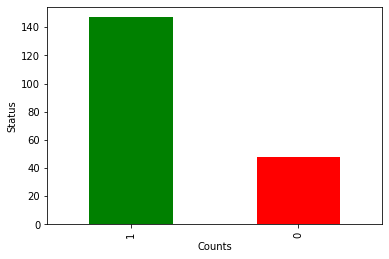

In [31]:
import matplotlib.pyplot as plt
df['status'].value_counts().plot(kind='bar',color=['green','red'])
plt.xlabel('Counts')
plt.ylabel("Status")
plt.show()

# Getting Confusion matrix and its heatmap

Confusion mtrix = 
 [[ 5  2]
 [ 0 32]] 




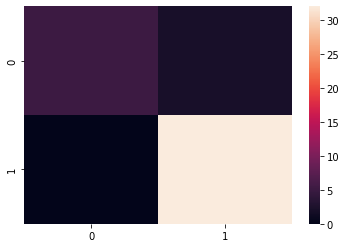

In [36]:
import seaborn as sns
print("Confusion mtrix = \n",confusion_matrix(y_test,y_pred),"\n\n")
sns.heatmap(confusion_matrix(y_test,y_pred))
plt.show()